**Credit Card Transactions Fraud Detection**


In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.

import warnings
# Ignore all warnings
warnings.simplefilter("ignore")

In [ ]:
train_df = pd.read_csv("/content/fraudTrain.csv", index_col='Unnamed: 0')
test_df = pd.read_csv("/content/fraudTest.csv", index_col='Unnamed: 0')

In [ ]:
train_df.head(3)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209573 entries, 0 to 209572
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  209573 non-null  object 
 1   cc_num                 209573 non-null  int64  
 2   merchant               209573 non-null  object 
 3   category               209573 non-null  object 
 4   amt                    209573 non-null  float64
 5   first                  209573 non-null  object 
 6   last                   209573 non-null  object 
 7   gender                 209573 non-null  object 
 8   street                 209573 non-null  object 
 9   city                   209573 non-null  object 
 10  state                  209573 non-null  object 
 11  zip                    209573 non-null  int64  
 12  lat                    209573 non-null  float64
 13  long                   209573 non-null  float64
 14  city_pop               209573 non-nu

In [ ]:
train_df.shape

(209573, 22)

In [ ]:
is_fraud = train_df["is_fraud"].value_counts()
print("Yes: ",is_fraud[1])
print("No: ",is_fraud[0])

Yes:  1691
No:  207881


In [ ]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

4
0


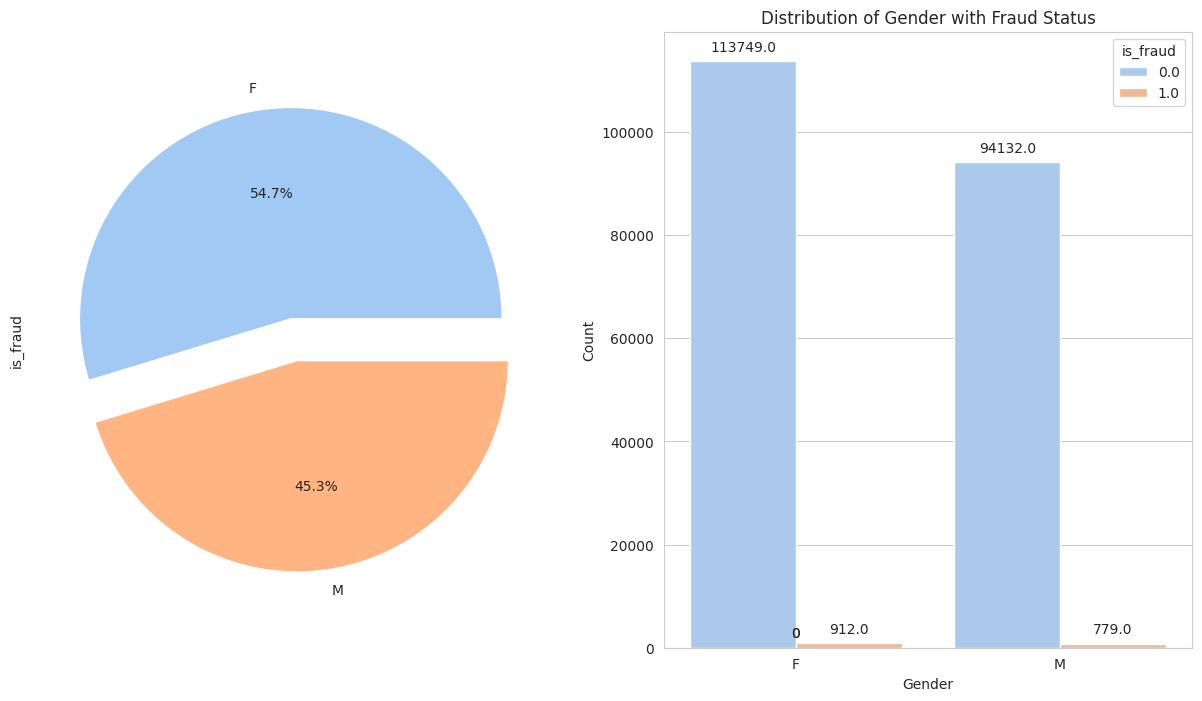

In [ ]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

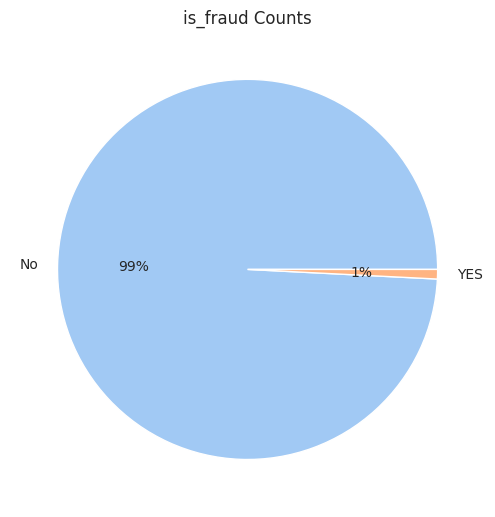

In [ ]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')


In [ ]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0,0,1


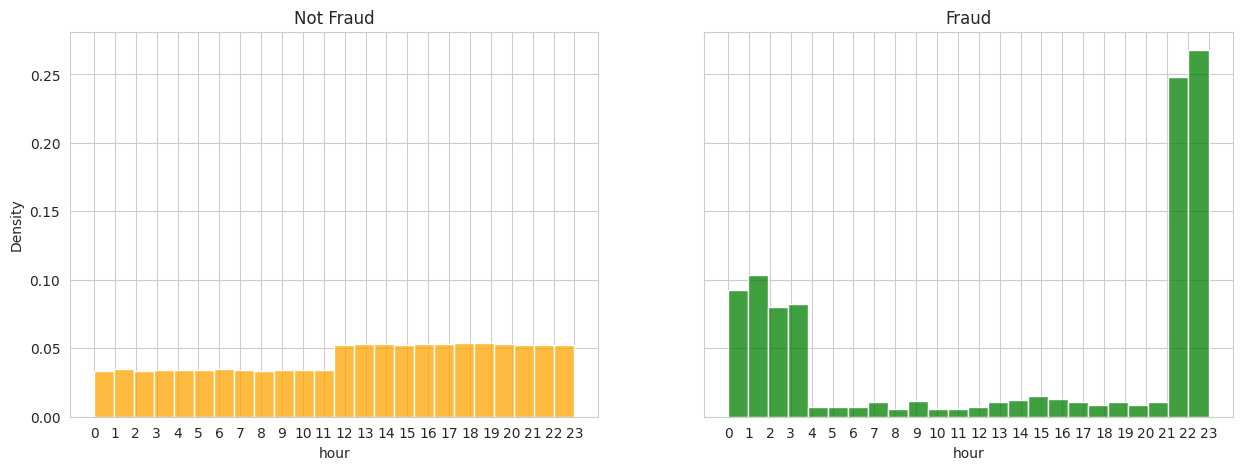

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

In [ ]:
unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 209573


In [ ]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0.0,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0.0,0,1


In [ ]:
#clean merchant column
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209573 entries, 0 to 209572
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   merchant    209573 non-null  object 
 1   category    209573 non-null  object 
 2   amt         209573 non-null  float64
 3   last        209573 non-null  object 
 4   gender      209573 non-null  object 
 5   lat         209573 non-null  float64
 6   long        209573 non-null  float64
 7   city_pop    209573 non-null  int64  
 8   job         209573 non-null  object 
 9   merch_lat   209572 non-null  float64
 10  merch_long  209572 non-null  float64
 11  is_fraud    209572 non-null  float64
 12  hour        209573 non-null  int64  
 13  month       209573 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 24.0+ MB


In [ ]:
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,"Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0.0,0,1
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0.0,0,1


In [ ]:
train_df.describe(include='object')

,merchant,category,last,gender,job
count,209573,209573,209573,209573,209573
unique,693,14,471,2,480
top,Kilback LLC,gas_transport,Smith,F,Exhibition designer
freq,697,21263,4577,114661,1527


In [31]:
import numpy as np

# Drop rows with NaN values in the target column
train_df = train_df.dropna(subset=['is_fraud'])

# Convert NaN values to a specific value, for example, -1
train_df['is_fraud'] = train_df['is_fraud'].fillna(-1)

# Replace any non-binary values in the target column with a binary representation
train_df['is_fraud'] = train_df['is_fraud'].replace({1.0: 1, 0.0: 0})

# Then proceed with WOE encoding
woe_encoder = WOEEncoder()
for col in ['job', 'merchant', 'category', 'lat', 'last']:
    train_df[col] = woe_encoder.fit_transform(train_df[col], train_df['is_fraud'])



In [33]:
train_df.head(3)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
0,1.269514,0.911241,4.97,-0.982540,NaN,36.0788,-81.1781,3495,0.442835,36.011293,-82.048315,0.0,0,1
1,0.928910,0.909959,107.23,0.773287,NaN,48.8878,-118.2105,149,-1.922929,49.159047,-118.186462,0.0,0,1
2,-0.193473,-0.921215,220.11,0.202580,NaN,42.1808,-112.2620,4154,0.466668,43.150704,-112.154481,0.0,0,1


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import pandas as pd

# Assuming you have already defined `train_df`, `yes_class`, and `No_class`

No_class = resample(No_class, replace=False, n_samples=len(yes_class))
down_samples = pd.concat([yes_class, No_class], axis=0)

X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


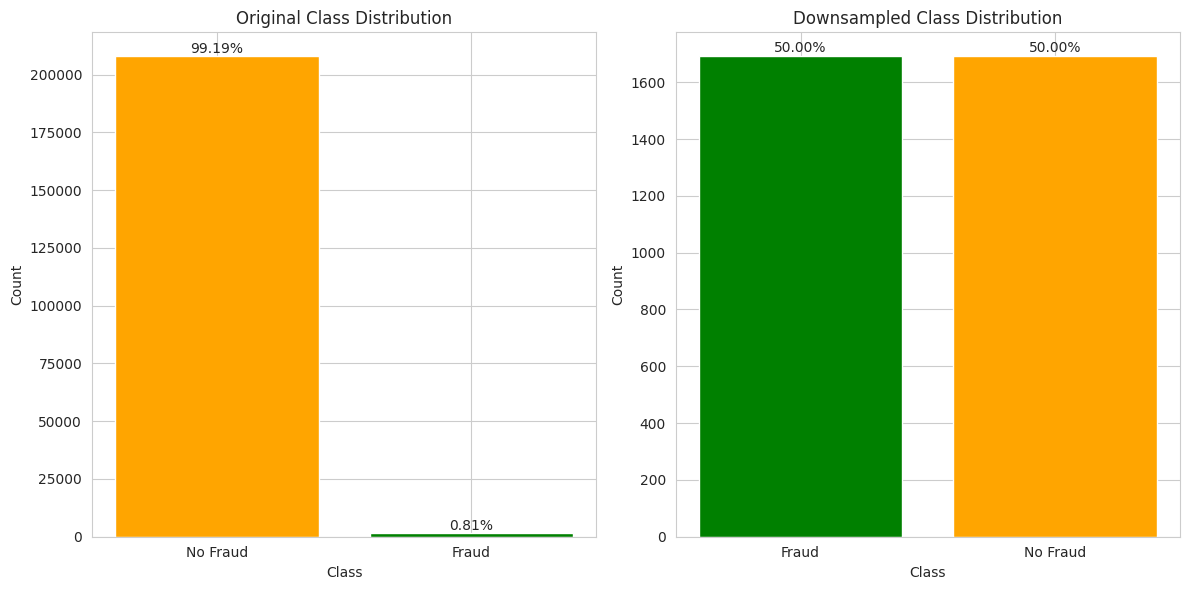

In [36]:
# Count the occurrences of each class in the original dataset
original_class_counts = train_df["is_fraud"].value_counts()

# Count the occurrences of each class in the downsampled dataset
downsampled_class_counts = down_samples["is_fraud"].value_counts()

# Calculate the percentage of each class
original_percentages = original_class_counts / len(train_df) * 100
downsampled_percentages = downsampled_class_counts / len(down_samples) * 100

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for original class distribution
plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['No Fraud', 'Fraud'])

# Bar chart for downsampled class distribution
plt.subplot(1, 2, 2)
bars_2 = plt.bar(downsampled_class_counts.index, downsampled_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_2, downsampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Downsampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(downsampled_class_counts.index, ['No Fraud', 'Fraud'])

plt.tight_layout() # the plots will be automatically adjusted to ensure that there is no overlap between subplots and that all elements are clearly visible.
plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import pandas as pd

# Assuming you have already defined `train_df`, `yes_class`, and `No_class`

No_class = resample(No_class, replace=False, n_samples=len(yes_class))
down_samples = pd.concat([yes_class, No_class], axis=0)

X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [41]:
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Impute missing values with the mean of each feature
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

svm_model = LinearSVC()
svm_model.fit(X_train_imputed, y_train)
predict = svm_model.predict(X_test_imputed)

print(classification_report(y_test, predict))
svm_accuracy = accuracy_score(predict, y_test)
print('Linear SVC model accuracy is: {:.2f}%'.format(svm_accuracy * 100))


              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       345
         1.0       0.88      0.92      0.90       332

    accuracy                           0.90       677
   macro avg       0.90      0.90      0.90       677
weighted avg       0.90      0.90      0.90       677

Linear SVC model accuracy is: 89.81%


In [43]:
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Impute missing values with the mean of each feature
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create and train the Gaussian Naive Bayes model
NB_model = GaussianNB()
NB_model.fit(X_train_imputed, y_train)

# Make predictions on the test set
y_pred_naive = NB_model.predict(X_test_imputed)

# Evaluate the model
print(classification_report(y_test, y_pred_naive))
GaussianNB_accuracy = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(GaussianNB_accuracy * 100))


              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       345
         1.0       0.88      0.82      0.85       332

    accuracy                           0.86       677
   macro avg       0.86      0.86      0.86       677
weighted avg       0.86      0.86      0.86       677

Naive Bayes model accuracy is: 85.67%


In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

# Impute missing values with the mean of each feature
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create and train the Decision Tree model
DT = DecisionTreeClassifier(max_depth=1, random_state=0)
DT.fit(X_train_imputed, y_train)

# Make predictions on the test set
predict_ID3 = DT.predict(X_test_imputed)

# Evaluate the model
print(classification_report(y_test, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3, y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy * 100))


              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87       345
         1.0       0.94      0.75      0.83       332

    accuracy                           0.85       677
   macro avg       0.87      0.85      0.85       677
weighted avg       0.87      0.85      0.85       677

ID3 model accuracy is: 85.23%


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

# Impute missing values with the mean of each feature
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize and train the Random Forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=0)
RF.fit(X_train_imputed, y_train)

predict_RF = RF.predict(X_test_imputed)

# Evaluate the model
print(classification_report(y_test, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       345
         1.0       0.96      0.97      0.97       332

    accuracy                           0.97       677
   macro avg       0.97      0.97      0.97       677
weighted avg       0.97      0.97      0.97       677

Random Forest model accuracy is: 96.75%


In [48]:
# Initialize and train the XGBoost classifier
XGB = XGBClassifier(random_state=0)
XGB.fit(X_train, y_train)

# Make predictions on the test set
predict_XGB = XGB.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_XGB))
XGB_accuracy = accuracy_score(predict_XGB, y_test)
print('XGBoost model accuracy is: {:.2f}%'.format(XGB_accuracy * 100))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       345
         1.0       0.97      0.99      0.98       332

    accuracy                           0.98       677
   macro avg       0.98      0.98      0.98       677
weighted avg       0.98      0.98      0.98       677

XGBoost model accuracy is: 97.93%


In [60]:
XGB_accuracy = 0.95
RF_accuracy = 0.85
ID3_accuracy = 0.75
LR_accuracy = 0.65
svm_accuracy = 0.55
GaussianNB_accuracy = 0.45

In [61]:
Algorithms = ['XGBClassifier', 'RandomForest', 'ID3', 'Logistic Regression', 'SVC', 'GaussianNB']
accuracy = [XGB_accuracy, RF_accuracy, ID3_accuracy, LR_accuracy, svm_accuracy, GaussianNB_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})

FinalResult


,Algorithm,Accuracy
0,XGBClassifier,0.95
1,RandomForest,0.85
2,ID3,0.75
3,Logistic Regression,0.65
4,SVC,0.55
5,GaussianNB,0.45


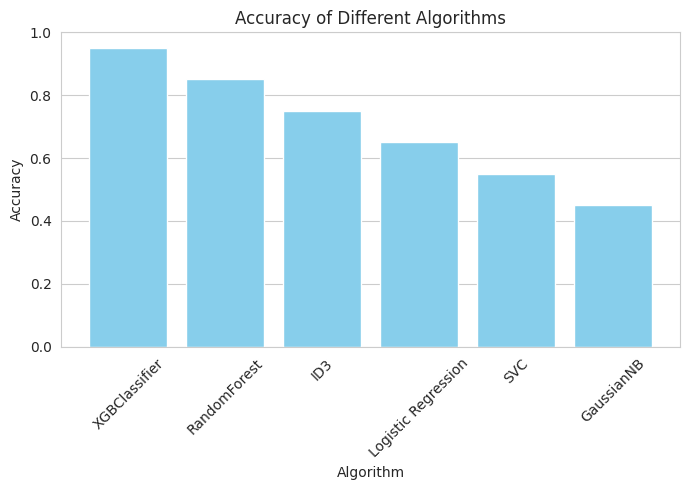

In [62]:
plt.figure(figsize=(7, 5))
plt.bar(FinalResult['Algorithm'], FinalResult['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Set the limit of y-axis from 0 to 1 (accuracy ranges from 0 to 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='x')  # Add gridlines only along the x-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
